# Calculating the shortes distance from house to Geo

In [3]:
#pip install geopy
#pip install geopandas

In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.spatial.distance import cdist
from geopy.distance import geodesic

In [45]:
# Indlæsning af datasets
housing_data = pd.read_csv('Boligsiden_med_år.csv')
geo_data = pd.read_csv('GEO_dataset.csv')

# Fjern rækker med manglende værdier i 'Latitude' og 'Longitude' kolonnerne
housing_data = housing_data.dropna(subset=['Latitude', 'Longitude'])
geo_data = geo_data.dropna(subset=['Latitude', 'Longitude'])

In [47]:
# Bestem de unikke POI-kategorier fra geo_data
poi_categories = geo_data['Type'].unique()

# Forbered ordbøger til at gemme resultater: en til afstande og en til koordinater
distance_results = {}
coordinate_results = {}

# Beregn afstande for hver POI-kategori
for category in poi_categories:
    # Filtrer geo_data for den aktuelle POI-kategori
    filtered_geo_data = geo_data[geo_data['Type'] == category]
    
    # Beregn parvise afstande mellem alle huse og POI'er i den aktuelle kategori
    distance_matrix = cdist(housing_data[['Latitude', 'Longitude']], filtered_geo_data[['Latitude', 'Longitude']])
    
    # Identificer den mindste afstand for hvert hus
    closest_distances = np.min(distance_matrix, axis=1)
    
    # Find indeksene for de nærmeste POI'er
    closest_indices = np.argmin(distance_matrix, axis=1)
    
    # Uddrag koordinaterne for de nærmeste POI'er
    nearest_coordinates = [(filtered_geo_data.iloc[idx]['Latitude'], filtered_geo_data.iloc[idx]['Longitude']) for idx in closest_indices]
    
    # Gem koordinaterne med meningsfulde kolonnenavne
    coordinate_results[f"nearest_{category}_lat"] = [coords[0] for coords in nearest_coordinates]
    coordinate_results[f"nearest_{category}_lon"] = [coords[1] for coords in nearest_coordinates]


In [48]:
# Saml koordinaterne i en ny DataFrame
coordinate_df = pd.DataFrame(coordinate_results)

# Fjern rækker med NaN-værdier i koordinat-DataFrame'en (hvis nogen)
coordinate_df.dropna(inplace=True)


In [49]:
# Beregn geodesiske afstande
distance_columns = []
for category in poi_categories:
    distance_column = f"dist_to_{category}"
    coordinate_df[distance_column] = [
        geodesic((house_lat, house_lon), (poi_lat, poi_lon)).kilometers
        for house_lat, house_lon, poi_lat, poi_lon
        in zip(housing_data['Latitude'], housing_data['Longitude'],
               coordinate_df[f"nearest_{category}_lat"],
               coordinate_df[f"nearest_{category}_lon"])
    ]
    distance_columns.append(distance_column)


In [50]:
# Kombiner de oprindelige data med de beregnede afstande
final_df = pd.concat([housing_data.reset_index(drop=True), coordinate_df[distance_columns].reset_index(drop=True)], axis=1)

# Gem den endelige DataFrame som en CSV-fil
final_df.to_csv("Processed_Housing_Data.csv", index=False)

# Vis den endelige DataFrame
final_df


,Adress,City,Street name,Postal code,Latitude,Longitude,Rooms,Property type,Energy label,Price,...,Elementary school expense (mio.),Year built,Bathrooms,dist_to_Public Transport Stations,dist_to_Beaches,dist_to_Schools,dist_to_Restaurants,dist_to_Hospitals,dist_to_Malls,dist_to_Supermarkets
0,"Nørregade 27, Agerskov 6534",Agerskov,Nørregade,6534,55.130960,9.136025,4,Villa,E,495000,...,216.587,1947.0,1.0,16.937517,33.888472,0.218910,0.420885,16.986235,32.349696,8.100554
1,"Keldsvej 5, Store Fuglede 4480",Store Fuglede,Keldsvej,4480,55.577656,11.180144,7,Villa,C,1695000,...,280.686,1900.0,2.0,11.508389,28.718417,1.954803,9.338248,22.943350,10.673426,5.429859
2,"Tofteengen 8, Roskilde 4000",Roskilde,Tofteengen,4000,55.693270,12.147028,7,Villa,NaN,6495000,...,652.521,2017.0,2.0,5.142713,4.930456,1.622775,2.926239,7.211322,6.758098,4.860035
3,"Længstedal 16, Skjern 6900",Skjern,Længstedal,6900,56.003277,8.696856,7,Villa,C,1495000,...,370.434,1979.0,2.0,3.319680,14.497442,5.857701,5.974750,20.908849,29.103602,10.622460
4,"Åskrænten 22, Egå 8250",Egå,Åskrænten,8250,56.203278,10.264264,5,Villa,C,6998000,...,2226.985,1962.0,2.0,1.937711,1.270812,1.098538,1.355281,5.404396,3.411354,1.215941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9910,"Bødkerstræde 10, Karlslunde 2690",Karlslunde,Bødkerstræde,2690,55.570120,12.224564,6,Villa,C,5995000,...,370.660,1788.0,2.0,4.115616,2.672530,0.262239,1.427502,3.071907,2.343683,0.218098
9911,"Odinsvej 2, Kirke Såby 4060",Kirke Såby,Odinsvej,4060,55.651460,11.880332,3,Villa,C,1645000,...,197.365,1953.0,1.0,6.387605,3.677477,1.707735,6.612146,12.249469,13.359499,6.426935
9912,"Purupvej 14, Østbirk 8752",Østbirk,Purupvej,8752,55.987175,9.734029,5,Villa,E,2495000,...,631.385,1910.0,1.0,11.691203,10.109543,2.951033,0.942083,16.320359,13.302073,9.313335
9913,"Vinkelvej 9, Ulfborg 6990",Ulfborg,Vinkelvej,6990,56.375076,8.121837,1,Villa,D,695000,...,352.497,1953.0,1.0,13.806256,30.125570,8.263172,0.931642,22.786710,30.593379,14.250801


## Data cleanup 

In [52]:
# Remove columns related to object coordinates
coords_columns = [column for column in final_df.columns if "_lat" in column or "_lon" in column]
cleaned_df = final_df.drop(columns=coords_columns)

# Remove unnecessary columns like "City" and "Postal code"
#cleaned_df = cleaned_df.drop(columns=["City", "Postal code"])

# Rename columns for better readability
rename_mapping = {
    "dist_to_Public Transport Stations": "Transport Station Distance (km)",
    "dist_to_Beaches": "Beach Distance (km)",
    "dist_to_Schools": "School Distance (km)",
    "dist_to_Restaurants": "Restaurant Distance (km)",
    "dist_to_Hospitals": "Hospital Distance (km)",
    "dist_to_Malls": "Mall Distance (km)",
    "dist_to_Supermarkets": "Supermarkets Distance (km)",
}

cleaned_df = cleaned_df.rename(columns=rename_mapping)

# Export the cleaned data to a CSV file
cleaned_df.to_csv("Processed_Housing_Data_Final.csv", index=False)

# Preview the first 50 rows of the cleaned dataset
cleaned_df.head(50)


,Adress,City,Street name,Postal code,Latitude,Longitude,Rooms,Property type,Energy label,Price,...,Elementary school expense (mio.),Year built,Bathrooms,Transport Station Distance (km),Beach Distance (km),School Distance (km),Restaurant Distance (km),Hospital Distance (km),Mall Distance (km),Supermarkets Distance (km)
0,"Nørregade 27, Agerskov 6534",Agerskov,Nørregade,6534,55.130960,9.136025,4,Villa,E,495000,...,216.587,1947.0,1.0,16.937517,33.888472,0.218910,0.420885,16.986235,32.349696,8.100554
1,"Keldsvej 5, Store Fuglede 4480",Store Fuglede,Keldsvej,4480,55.577656,11.180144,7,Villa,C,1695000,...,280.686,1900.0,2.0,11.508389,28.718417,1.954803,9.338248,22.943350,10.673426,5.429859
2,"Tofteengen 8, Roskilde 4000",Roskilde,Tofteengen,4000,55.693270,12.147028,7,Villa,NaN,6495000,...,652.521,2017.0,2.0,5.142713,4.930456,1.622775,2.926239,7.211322,6.758098,4.860035
3,"Længstedal 16, Skjern 6900",Skjern,Længstedal,6900,56.003277,8.696856,7,Villa,C,1495000,...,370.434,1979.0,2.0,3.319680,14.497442,5.857701,5.974750,20.908849,29.103602,10.622460
4,"Åskrænten 22, Egå 8250",Egå,Åskrænten,8250,56.203278,10.264264,5,Villa,C,6998000,...,2226.985,1962.0,2.0,1.937711,1.270812,1.098538,1.355281,5.404396,3.411354,1.215941
5,"Ladelundsvej 10, Silkeborg 8600",Silkeborg,Ladelundsvej,8600,56.178215,9.512037,5,Villa,C,4195000,...,728.249,1972.0,2.0,2.555087,3.160440,0.608036,2.450265,3.008537,30.842063,2.323829
6,"Anders Olesens Vej 1, Løkken 9480",Løkken,Anders Olesens Vej,9480,57.338497,9.774502,2,Villa,F,525000,...,371.608,1960.0,1.0,5.033668,6.849697,5.418467,4.128320,18.390933,14.939461,0.106477
7,"Terslev Bygade 13, Haslev 4690",Haslev,Terslev Bygade,4690,55.374750,11.969055,6,Villa,C,1295000,...,187.668,1677.0,2.0,5.067719,16.422729,1.161821,5.139682,4.373683,14.441643,5.124702
8,"Blüchers Alle 10, Varde 6800",Varde,Blüchers Alle,6800,55.649050,8.680523,3,Villa,C,698000,...,344.515,1964.0,1.0,6.770304,25.653456,1.237394,5.684895,13.357373,12.888861,8.503185
9,"Bellisvej 8, Regstrup 4420",Regstrup,Bellisvej,4420,55.673058,11.622580,4,Villa,C,2995000,...,395.141,1997.0,2.0,0.800143,25.610601,1.090787,8.576628,7.304583,7.112189,0.263831


# Data Exploration

In [54]:
import seaborn as sns

# Anvend en raffineret stil til plottet
sns.set_style("whitegrid")
sns.set_palette("deep")

# Indlæs datasættet
data = pd.read_csv('Processed_Housing_Data_Final.csv')

# Fjern eventuelle utilsigtede mellemrum fra kolonnenavnene
data.columns = data.columns.str.strip()

# Debug: Udskriv kolonnenavnene for at sikre, at de er korrekte
print("Kolonnenavne i datasættet:", data.columns)


Kolonnenavne i datasættet: Index(['Adress', 'City', 'Street name', 'Postal code', 'Latitude', 'Longitude',
       'Rooms', 'Property type', 'Energy label', 'Price', 'Province',
       'Days on Market', 'Link', 'Off. vurdering', 'Home size',
       'Monthly expense', 'Ground size', 'Transport Station Distance (km)',
       'Beach Distance (km)', 'School Distance (km)',
       'Restaurant Distance (km)', 'Hospital Distance (km)',
       'Mall Distance (km)', 'Supermarkets Distance (km)',
       'Distance to Largest City (km)', 'Municipality', 'AverageAge',
       'NumberOfChildren', 'Men', 'Women', 'AverageIncome',
       'Elementary school', 'High school education', 'Vocational Education',
       'Short Higher Education', 'Intermediate Higher Education',
       'Bachelor's programmes', 'Longer Higher Education',
       'PhD and research programs', 'Special Education expense',
       'Healthcare expense', 'Green Spaces expense', 'Infrastructure expense',
       'Social Services expense',

In [55]:
# Definer målvariablen som "Price"
target_variable = "Price"

# Tjek om kolonnen "Price" eksisterer
if target_variable not in data.columns:
    raise ValueError(f"Kolonnen '{target_variable}' findes ikke i datasættet.")


In [56]:
# Vælg funktioner relateret til afstande
distance_columns = [col for col in data.columns if "Distance" in col]

# Debug: Udskriv de valgte distance-kolonner for at sikre, at de er korrekte
print("Afstandskolonner fundet:", distance_columns)


Afstandskolonner fundet: ['Transport Station Distance (km)', 'Beach Distance (km)', 'School Distance (km)', 'Restaurant Distance (km)', 'Hospital Distance (km)', 'Mall Distance (km)', 'Supermarkets Distance (km)', 'Distance to Largest City (km)', 'Transport Station Distance (km).1', 'Beach Distance (km).1', 'School Distance (km).1', 'Restaurant Distance (km).1', 'Hospital Distance (km).1', 'Mall Distance (km).1', 'Supermarkets Distance (km).1']


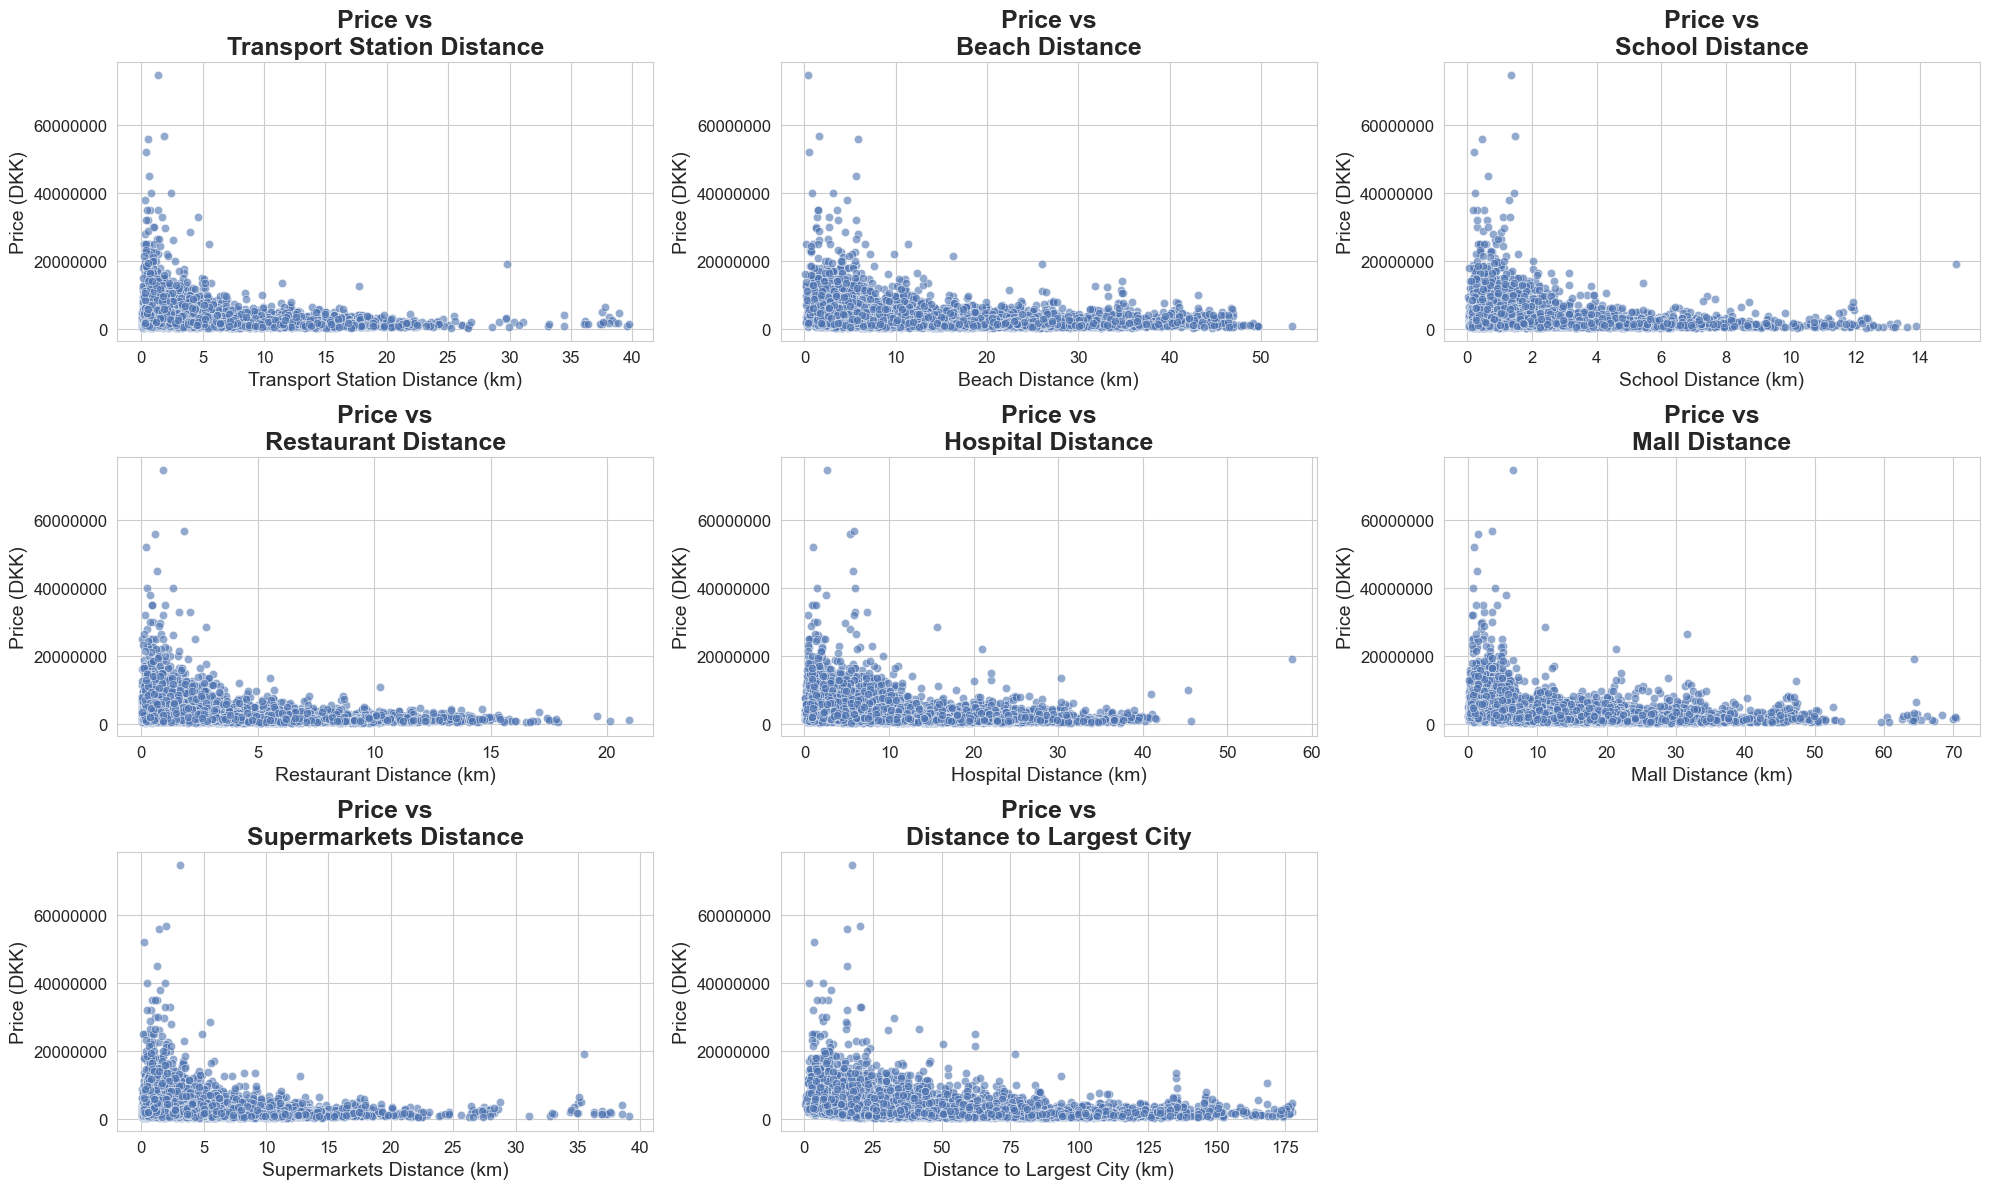

In [68]:
data = data.drop(columns=['Transport Station Distance (km).1', 'Beach Distance (km).1',
                          'School Distance (km).1', 'Restaurant Distance (km).1', 
                          'Hospital Distance (km).1', 'Mall Distance (km).1', 
                          'Supermarkets Distance (km).1'])

# Vælg funktioner relateret til afstande (kolonner, der indeholder ordet "Distance")
distance_columns = [col for col in data.columns if "Distance" in col]

# Generér scatter plots: 3 rækker x 3 kolonner grid
fig, axes = plt.subplots(3, 3, figsize=(20, 12))

for i, column in enumerate(distance_columns):
    row = i // 3
    col = i % 3
    axes[row, col].scatter(data[column], data[target_variable], alpha=0.6, edgecolor='w', linewidth=0.5)
    axes[row, col].set_title(f'Price vs\n{column.replace(" (km)", "")}', fontsize=18, fontweight='bold', ha='center')
    axes[row, col].set_xlabel(column, fontsize=14)
    axes[row, col].set_ylabel("Price (DKK)", fontsize=14)
    axes[row, col].tick_params(axis='both', which='major', labelsize=12)
    axes[row, col].ticklabel_format(style='plain', axis='y')

# Fjern eventuelle tomme subplot-områder
for ax in axes.flatten()[len(distance_columns):]:
    ax.remove()

# Juster layout og vis figuren
plt.tight_layout()
plt.show()



Generating Scatter Plots:  83%|██████████████   | 34/41 [00:33<00:06,  1.02it/s]

Generating Scatter Plots: 100%|█████████████████| 34/34 [00:01<00:00, 32.83it/s]


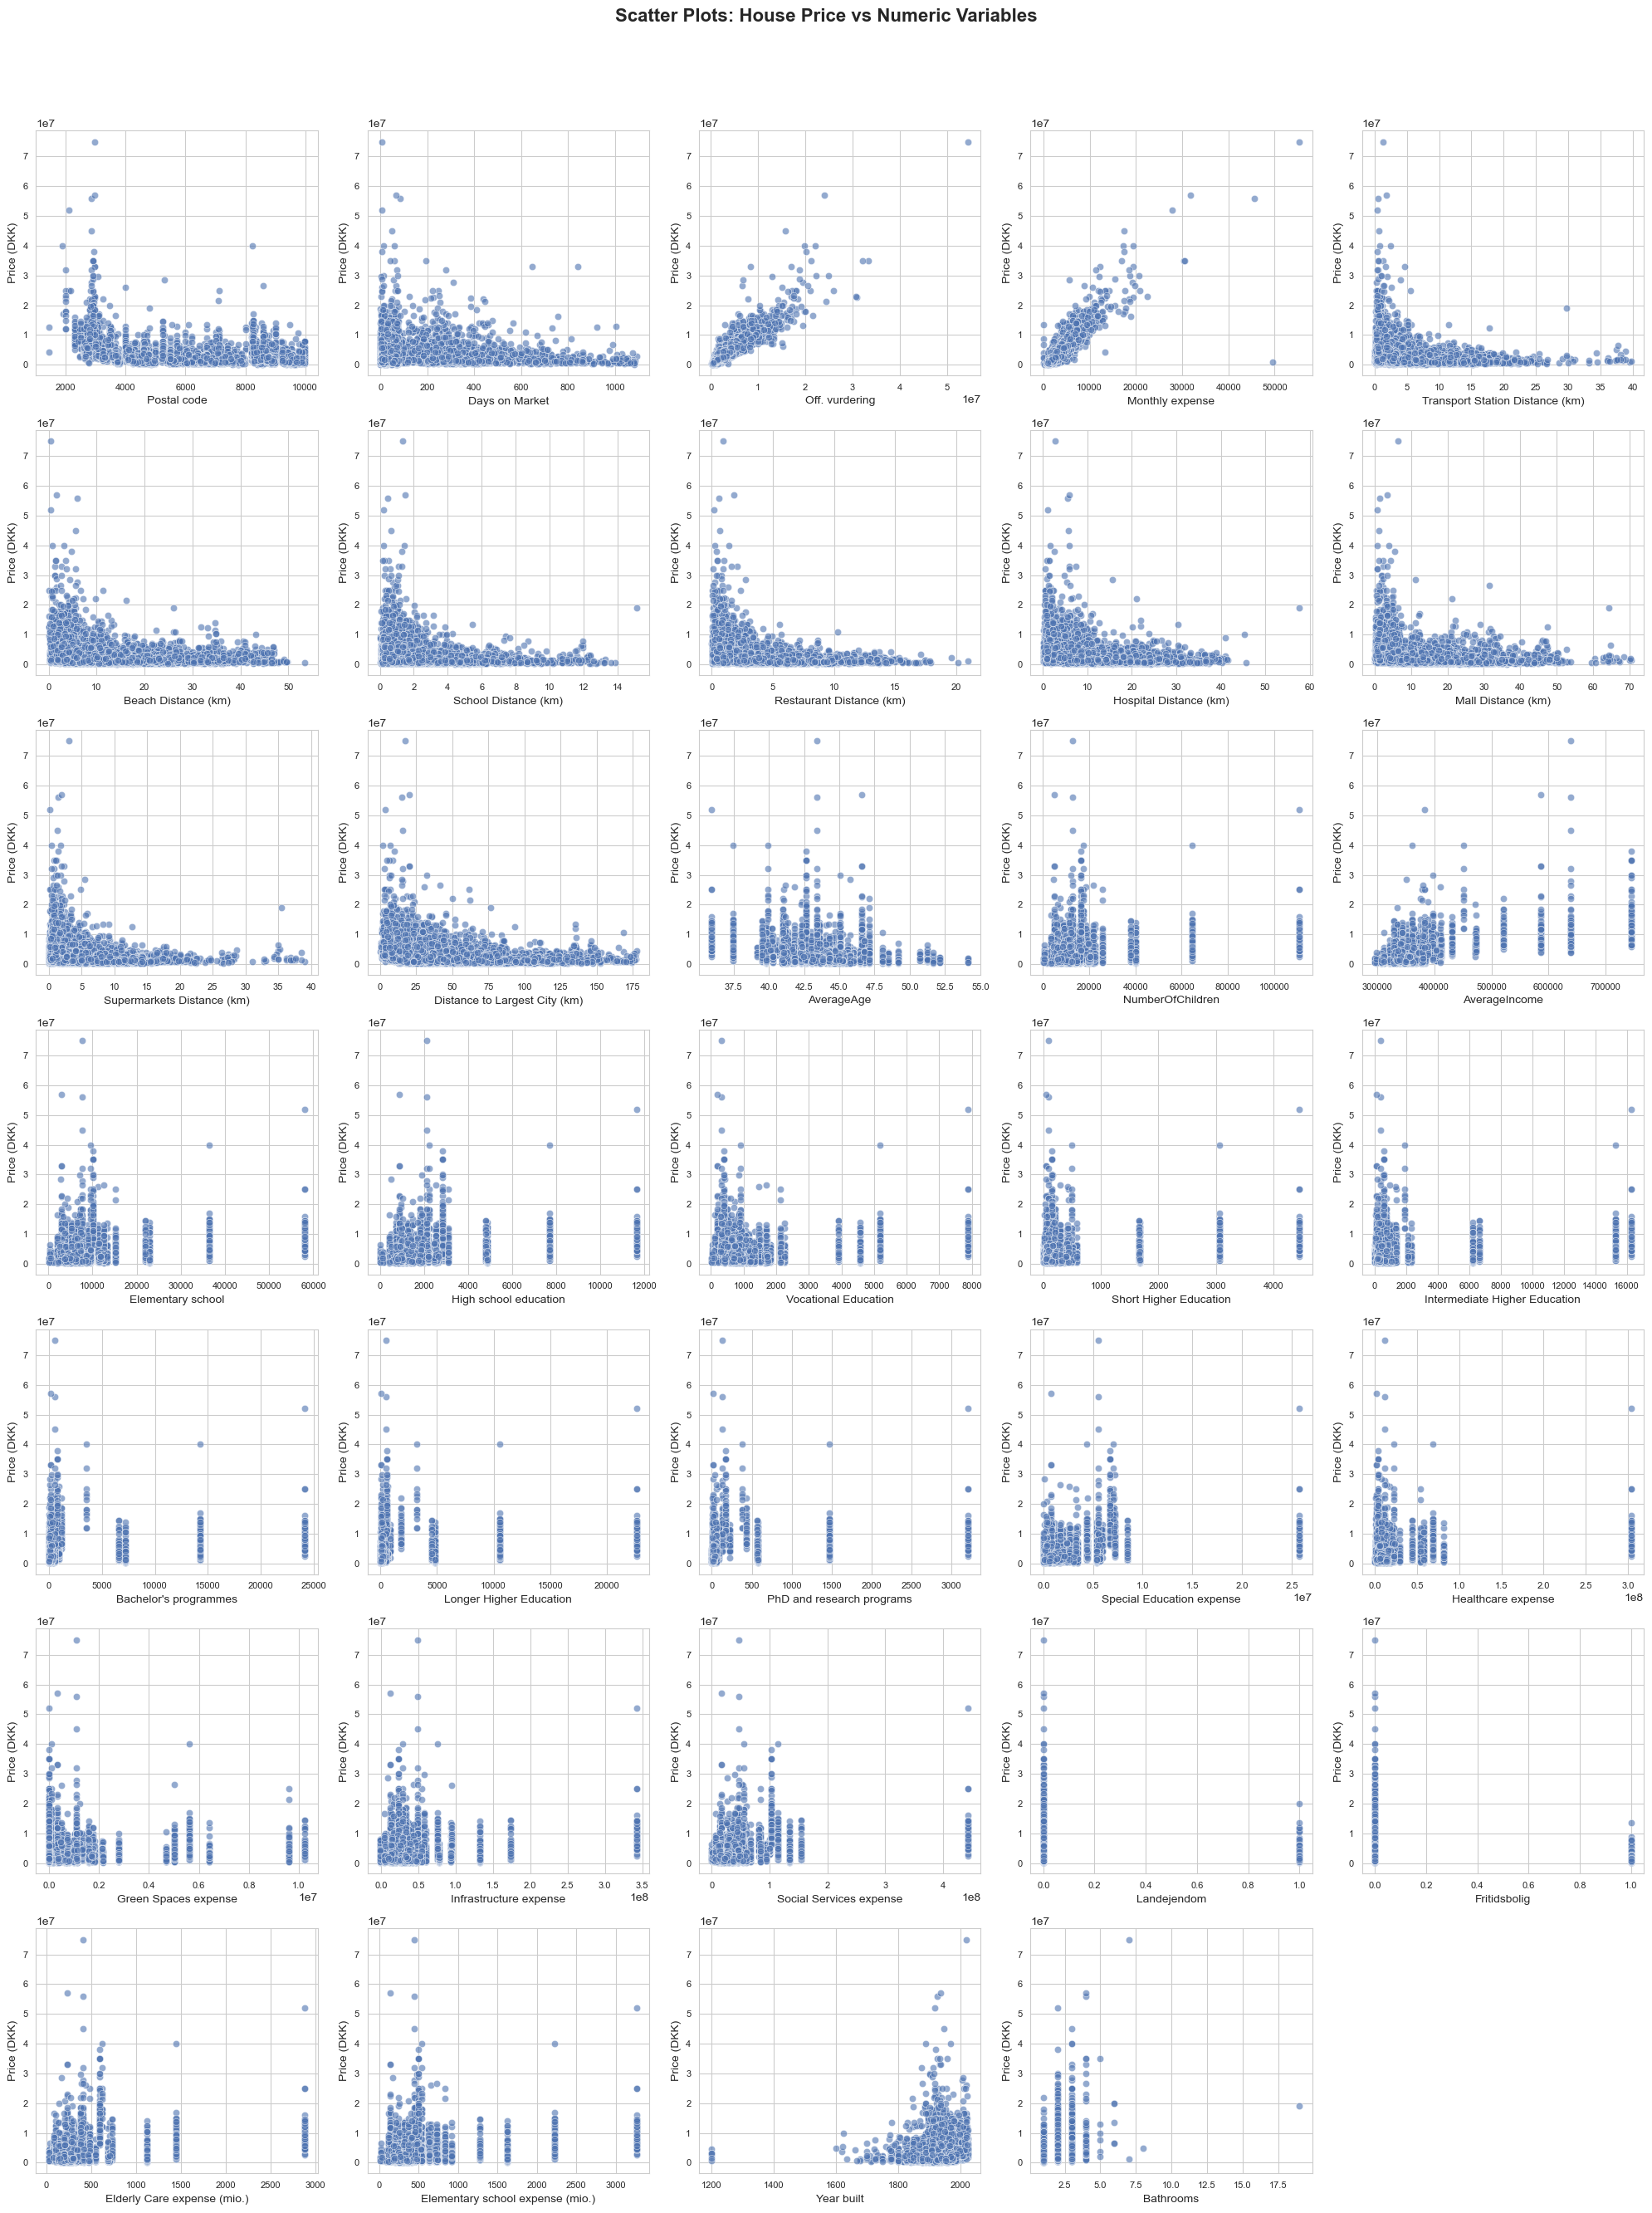

In [76]:
# Analysis focused on House Price

from tqdm import tqdm

# Apply a refined style for visualizations
sns.set_style("whitegrid")
sns.set_palette("deep")

# Load the dataset
data = pd.read_csv('Processed_Housing_Data_Final.csv')

data = data.drop(columns=['Transport Station Distance (km).1', 'Beach Distance (km).1',
                          'School Distance (km).1', 'Restaurant Distance (km).1', 
                          'Hospital Distance (km).1', 'Mall Distance (km).1', 
                          'Supermarkets Distance (km).1'])

# Remove non-relevant columns like 'Latitude', 'Longitude', and 'House Price'
columns_to_ignore = ['Latitude', 'Longitude', 'Price', 'Men', 'Women']
numeric_data = data.select_dtypes(include=['number']).drop(columns=columns_to_ignore)

# Retrieve the 'Price' column
price = data['Price']

# Determine the grid size dynamically based on the number of features
total_columns = numeric_data.shape[1]
grid_cols = 5
grid_rows = int(np.ceil(total_columns / grid_cols))

# Initialize tqdm to track progress
pbar = tqdm(total=total_columns, desc="Generating Scatter Plots")

# Set figure size
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(20, grid_rows * 4))

# Flatten axes array for easy indexing
axes = axes.flatten()

for i, feature in enumerate(numeric_data.columns):
    sns.scatterplot(data=data, x=feature, y=price, alpha=0.6, edgecolor='w', linewidth=0.5, ax=axes[i])
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel("Price (DKK)", fontsize=10)
    axes[i].tick_params(axis='both', which='major', labelsize=8)
    
    # Update the progress bar after each plot
    pbar.update(1)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Close the progress bar once done
pbar.close()

# Add a main title for the plot grid
fig.suptitle("Scatter Plots: House Price vs Numeric Variables", fontsize=16, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("House_Price_Pairwise_Scatter_Plots.png", dpi=300)
plt.show()